In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

In [25]:
bAm = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/azul crystal/Am G40 -40.txt'
bCs = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/azul crystal/Cs G25 -40.txt'
bNa = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/azul crystal/Na G25 -60.txt'

nAm = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/blank crystal/Am G30 -60.txt'
nCs = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/blank crystal/Cs G25 -70.txt'
nNa = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/blank crystal/Na G20 -60.txt'

rAm = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/cristal rojo/Am G30 -40.txt'
rCs = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/cristal rojo/Cs G20 -40.txt'
rNa = '/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Calibration Data/cristal rojo/Na G30 -50.txt'

df_bAm = pd.read_table(bAm, decimal=',')
df_bCs = pd.read_table(bCs, decimal=',')
df_bNa = pd.read_table(bNa, decimal=',')

df_nAm = pd.read_table(nAm, decimal=',')
df_nCs = pd.read_table(nCs, decimal=',')
df_nNa = pd.read_table(nNa, decimal=',')

df_rAm = pd.read_table(rAm, decimal=',')
df_rCs = pd.read_table(rCs, decimal=',')
df_rNa = pd.read_table(rNa, decimal=',')

df_b = [df_bAm, df_bCs, df_bNa]
df_n = [df_nAm, df_nCs, df_nNa]
df_r = [df_rAm, df_rCs, df_rNa]

for i in df_b:
    i.columns = ['ADC', 'Counts']

for i in df_n:
    i.columns = ['ADC', 'Counts']

for i in df_r:
    i.columns = ['ADC', 'Counts']


In [26]:
def histogram(measurement, bins, conv_factor, color, title, save=False):

    plt.figure(figsize=(10,7), layout='constrained')
    plt.style.use('bmh')

    x = measurement['ADC']*conv_factor[0] + conv_factor[1]
    y = measurement['Counts']


    plt.hist(x,
             bins=bins,
             weights=y,
             color=color,
             density=True)

    plt.suptitle(f'{title}', fontsize=22)
    plt.xlabel('Energy / keV', fontsize=15)
    plt.xticks(fontsize=13)
    plt.ylabel('Probability Density', fontsize=15)
    plt.yticks(fontsize=13)

    plt.xlim(0,130)

    if save == True:
        plt.savefig(f'/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/Graphs/{title}.png', dpi=300, bbox_inches='tight')

    plt.show()


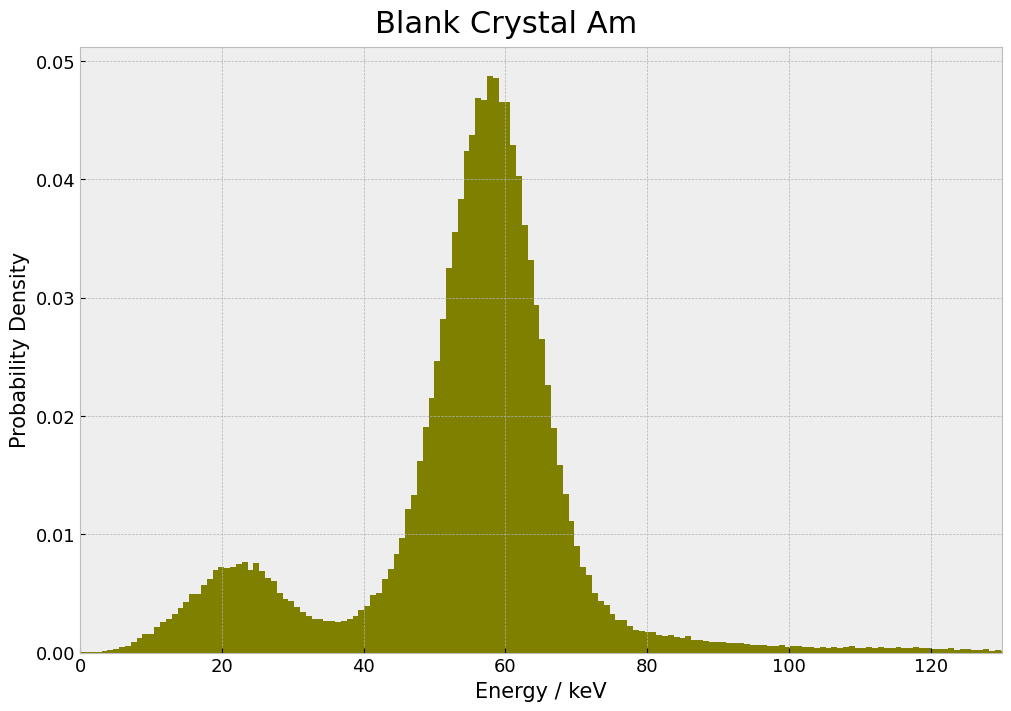

In [27]:
data = df_nAm

histogram(data, bins=1000, conv_factor=[0.0412,-8.7], color='olive', title='Blank Crystal Am', save=False)


In [119]:
def gaussian_function(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def calculate_fwhm_from_std_dev(std_dev):
    fwhm = 2 * np.sqrt(2 * np.log(2)) * std_dev
    return fwhm

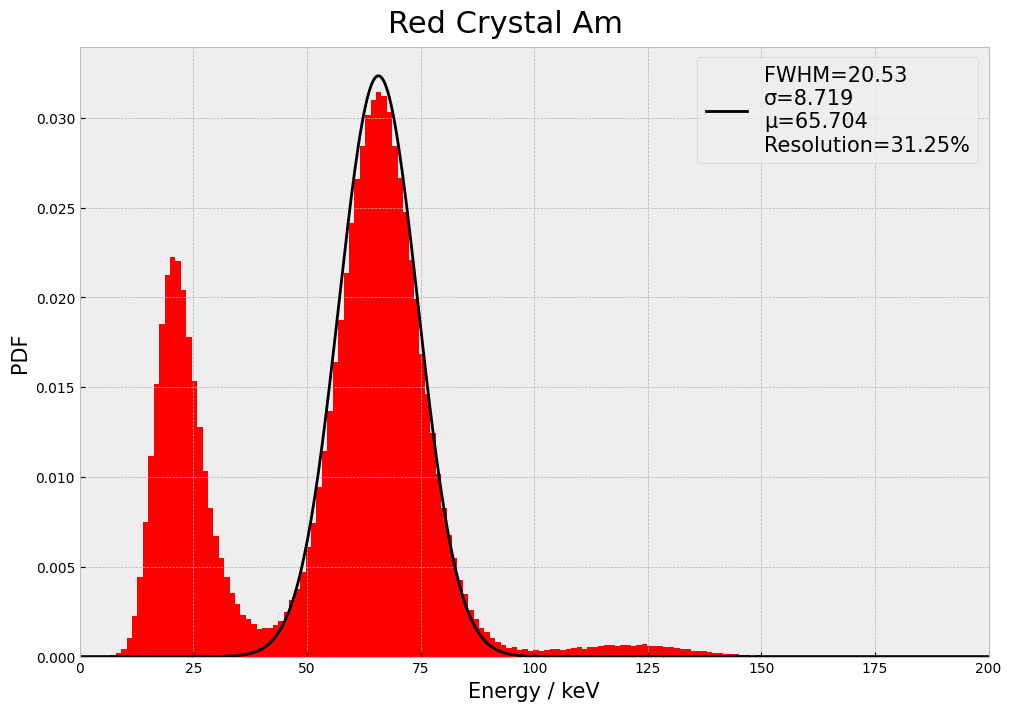

In [420]:
# The parameters
df = df_rAm
title = 'Red Crystal Am'
color = 'red'
conv_factor = [0.0597, 10.0]
space = 1000
min_value = 40
max_value = 125
gain = 0.73
save = True

# ------------------------------------------------------------------------------

plt.figure(figsize=(10,7), layout='constrained')

min_value = (min_value - conv_factor[1]) / conv_factor[0]
max_value = (max_value - conv_factor[1]) / conv_factor[0]

# Filter data within the specified range
filtered_data = df[(df['ADC'] >= min_value) & (df['ADC'] <= max_value)]

values_filtered = filtered_data['ADC'] * conv_factor[0] + conv_factor[1]
frequency_filtered = filtered_data['Counts']

hist_filtered, bin_edges_filtered = np.histogram(values_filtered, bins=space, weights=frequency_filtered, density=True)
bin_centers_filtered = (bin_edges_filtered[:-1] + bin_edges_filtered[1:]) / 2

popt_filtered, pcov_filtered = curve_fit(gaussian_function, bin_centers_filtered, hist_filtered, p0=[1, np.mean(values_filtered), np.std(values_filtered)])

amplitude_filtered, mean_filtered, stddev_filtered = popt_filtered


values_all = df['ADC'] * conv_factor[0] + conv_factor[1]
frequency_all = df['Counts']
plt.hist(values_all, bins=space, weights=frequency_all, density=True, color=color)

x_gauss = np.linspace(0, 200, 500)
y_hist = gaussian_function(x_gauss, amplitude_filtered*gain, mean_filtered, stddev_filtered)

# Getting the FWHM and the resolution
FWHM = calculate_fwhm_from_std_dev(stddev_filtered)

max_index = np.argmax(y_hist)

x_at_max = bin_centers_filtered[max_index]

plt.plot(x_gauss, y_hist, c='black', label=f'FWHM={round(FWHM, 2)}\nσ={round(stddev_filtered,3)}\nμ={round(mean_filtered,3)}\nResolution={round(FWHM * 100 / mean_filtered, 2)}%')

plt.xlim(0, 200)
plt.xlabel('Energy / keV', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.suptitle(title, fontsize=22)
plt.legend(fontsize=15)

if save == True:
    plt.savefig(f'/content/drive/Shareddrives/Physics Lab 4/Gamma Ray Spectroscopy/New_Graphs/{title}.png', dpi=300, bbox_inches='tight')

plt.show()
